# Text Classification with BERT using Neural Modules - Training

Begin by importing all of the required modules/functions/classes.

In [1]:
import nemo
import nemo.collections.nlp as nemo_nlp
from nemo.collections.nlp.data.datasets import BertTextClassificationDataset
from nemo.collections.nlp.nm.data_layers.text_classification_datalayer import BertTextClassificationDataLayer
from nemo.collections.nlp.nm.trainables import SequenceClassifier

from nemo.backends.pytorch.common import CrossEntropyLossNM
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.callbacks.text_classification_callback import eval_iter_callback, eval_epochs_done_callback

import os
import json
import math
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

import torch

from netapp_jupyter_utils import netappSnapshotCreate, netappGetSnapshots, netappRestoreSnapshot
from datetime import datetime


[NeMo W 2021-08-18 06:36:43 audio_preprocessing:56] Could not import torchaudio. Some features might not work.


# NetApp Volume Parameters

Enter the names of the Kubernetes PersistentVolume (PV) objects on which the dataset and model reside. These models are presented as simple folders within the Jupyter workspace through the NetApp AI Control Plane, where the ./data directory is the mounted dataset PV and the ./model directory is the mounted model PV. These PVs were provisioned using NetApp Trident prior to the start of the lab, and are pre-populated with the lab's required dataset and model data.

Notice that the NetApp storage constructs are abstracted away such that the user does not need to know or care that these directories actually represent mounted NetApp volumes, meaning data scientists aren't distracted by storage complexity.

In [2]:
# Note: PV = PersistentVolume
datasetPvName = 'pvc-99ca6eb3-0fbd-45bc-8309-654df8bef276' # Kubernetes PV on which the dataset resides (mounted at ./data)
modelPvName = 'pvc-f96acec3-e9eb-41c5-bcea-210aede85585' # Kubernetes PV on which trained models will be saved (mounted at ./model)

# This just allows Jupyter to re-use these values in the next notebook
%store datasetPvName
%store modelPvName

Stored 'datasetPvName' (str)
Stored 'modelPvName' (str)


# Dataset



Load the dataset.

...

## Data Exploration

...

## Save Dataset Baseline for Traceability

Save the datasets to disk so that you can later take advantage of NetApp Snapshot technology to save baselined dataset versions. The data transformation you performed here was simple, but these transformations are often complex and may require experimentation with multiple augmentations. NetApp Snapshots facilitate that need by giving you the ability to save off different versions of datasets in a near-instantaneous and highly storage-efficient manner. You will create a snapshot in the next section of this notebook.

Before training the model, use NetApp Snapshot technology to near-instaneously save a baseline version of the dataset for traceability.

First, define a unique tag and a description for the training run. You will use these items to identify the snapshots that correspond to this specific training run. 

In [6]:
trainingRunTag = 'bert_%s' % datetime.today().strftime('%Y%m%d_%H%M%S') # Training run tag = bert_timestamp
print('trainingRunTag: ', trainingRunTag)
trainingRunDescription = 'BERT training run.'

# This just allows Jupyter to re-use these values in the next notebook
%store trainingRunTag

trainingRunTag:  bert_20210818_063647
Stored 'trainingRunTag' (str)


Now, trigger the creation of a Snapshot copy to save a baseline version of the dataset.

A NetApp Snapshot copy is a read-only, point-in-time image of a volume. The image consumes minimal storage space and incurs negligible performance overhead because it only records file changes that have occurred since the last Snapshot was taken. This makes Snapshot copies ideal for saving versioned baselines of datasets and models, and for implementing dataset-to-model traceability. Since you are using the NetApp AI Control Plane, the underlying NetApp functionality is abstracted away, meaning you can trigger the creation of a Snapshot copy directly from within the notebook rather than having to navigate to an external NetApp-specific tool.

If you want more details on how this NetApp integration works, the "netappSnapshotCreate" method is defined in the netapp_jupyter_utils.py helper script found in the same directory as this notebook. That script leverages ONTAP REST APIs to create the snapshot on the desired PV. If you want to examine that script more closely, you can open the JupyterLab File Browser and double-click that script file to open it in an editor, just be careful not to change the file's contents or you may break the script, which in turn would break the correct operation of this notebook.

In [7]:
apiResponse, snapshot = netappSnapshotCreate(pvName = datasetPvName, snapshotName = trainingRunTag, snapshotComment = trainingRunDescription)

print('API Response: ', apiResponse['state'])
print('Snapshot uuid: ', snapshot['uuid'])
print('Snapshot name: ', snapshot['name'])
print('Snapshot description: ', snapshot['comment'])
print('Snapshot tag: ', trainingRunTag)

API Response:  success
Snapshot uuid:  a6b23954-ffee-11eb-b34c-0050569f4e90
Snapshot name:  bert_20210818_063647
Snapshot description:  BERT training run.
Snapshot tag:  bert_20210818_063647


# Neural Modules

...

...

## Pipelines

...

Pipelines define how data will flow through the different neural networks. In this case the data will flow through the BERT network and then the MLP network.

Note that this specific use of the term "Pipelines" refers to the general concept of "Pipelines", not to the Kubeflow Pipelines framework.

...

...

...

...

# Understanding and Visualizing BERT Embeddings

...

...

Draw a plot to visualize the words that the machine model classifies as expressing a "good" versus "bad" sentiment. 

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.001s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 2.210003
[t-SNE] KL divergence after 100 iterations with early exaggeration: 35.297852
[t-SNE] KL divergence after 700 iterations: 0.162491


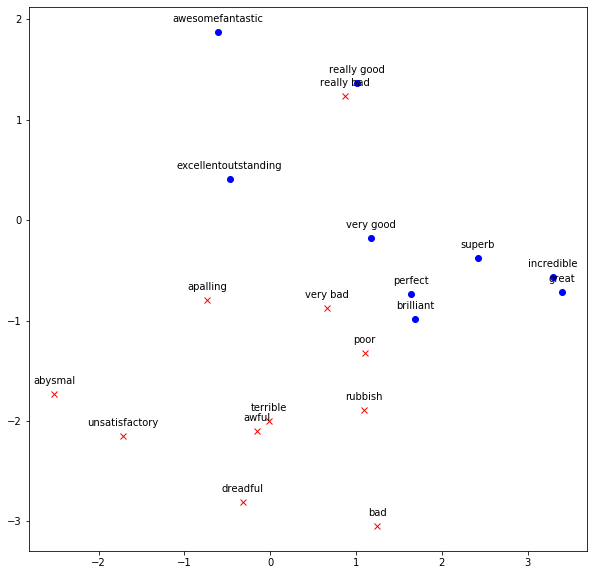

In [15]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:11, 0], tsne_spectrum[0:11, 1], 'rx')
plt.plot(tsne_spectrum[11:, 0], tsne_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In the preceding plot, "good" words are denoted by a blue dot, and "bad" words are denoted by a red x. If the model is effective, then you should expect "good" words to be closely clustered together and "bad" words to be closely clustered together, with both cluster groups widely separated into the lower-left and upper-right corners. That is not what you see here, so clearly there is room to improve this model, which you will attempt to accomplish shortly through further training.

# Training Pipeline 

## Save Baseline Version of Model

Before training the model, use NetApp Snapshot technology to save a baseline version of the model that you can revert back to in the event that you are not happy with the upcoming training results. Note that the size of a volume and the amount of data it contains does not factor into the time required to create an ONTAP snapshot. 

In [16]:
modelTag = 'baseline_' + trainingRunTag
modelDescription = 'Baseline pre-trained BERT model.'

bert.config.save_pretrained(MODELS_DIR)
torch.save(bert.state_dict(), MODELS_DIR + 'pytorch_model.bin') # Save pre-trained model to volume

apiResponse, snapshot = netappSnapshotCreate(pvName = modelPvName, snapshotName = modelTag, snapshotComment = modelDescription)

print('API Response: ', apiResponse['state'])
print('Snapshot uuid: ', snapshot['uuid'])
print('Snapshot name: ', snapshot['name'])
print('Snapshot description: ', snapshot['comment'])

API Response:  success
Snapshot uuid:  b3bc3ca1-ffee-11eb-b34c-0050569f4e90
Snapshot name:  baseline_bert_20210818_063647
Snapshot description:  Baseline pre-trained BERT model.


### Set up Training Pipeline

Use BERT embeddings to convert from words to a feature vector. This time you are using the full dataset, not just a small sample.

...

### Callbacks

...

### Train

...